In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from gpt3forchem.data import get_uspto_yield_data
from gpt3forchem.api_wrappers import fine_tune, query_gpt3, extract_regression_prediction
from gpt3forchem.input import create_reaction_yield_prompts

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import time

In [3]:
data = get_uspto_yield_data()

/Users/kevinmaikjablonka/git/kjappelbaum/gpt3forchem/gpt3forchem/data.py:226: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(datadir, "USTPO_yields.csv"))


In [4]:
data

,reaction_smiles,yield,mass,yield_text,dl:documentId,dl:paragraphNum,dl:paragraphText,paragraph_without_yield,paragraph_without_yield_and_charac,dl:headingText
0,[CH2:1]([O:3][C:4](=[O:11])[C@@H:5]1[CH2:9][CH...,98.9,323.00,to give 323 g (100%) of N-Boc- L-pyroglutamic ...,USRE044186E1,214,"L-pyroglutamic acid ethyl ester (200 g, 1.27 m...","L-pyroglutamic acid ethyl ester (200 g, 1.27 m...","L-pyroglutamic acid ethyl ester (200 g, 1.27 m...",NaN
1,[C:1]([O:6][CH2:7][CH2:8][O:9][C:10]1[CH:15]=[...,162.8,96.50,to obtain 96.5 g of a phenoxyethyl methacrylat...,US08430493B2,315,88 g of methyl ethyl ketone was added to a 100...,88 g of methyl ethyl ketone was added to a 100...,88 g of methyl ethyl ketone was added to a 100...,NaN
2,[N:1]1[C:5]2[CH:6]=[CH:7][CH:8]=[CH:9][C:4]=2[...,88.4,109.40,"leaving an orange oil, which",US08431045B2,445,"To a flask were added 100 g benzimidazole, 44 ...","To a flask were added 100 g benzimidazole, 44 ...","To a flask were added 100 g benzimidazole, 44 ...",Lq=1-Ethyl-1H-benzimidazole
3,[CH2:1]([C:11]1[NH:15][C:14]2[CH:16]=[CH:17][C...,151.0,0.90,resulted in an oil which,US08431045B2,452,"To a flask were added 0.79 g 2,2′-methylenebis...","To a flask were added 0.79 g 2,2′-methylenebis...","To a flask were added 0.79 g 2,2′-methylenebis...","2,2′-butane-1,1-diylbis(1-propyl-1H-benzimidaz..."
4,[N:1]1[CH:6]=[CH:5][CH:4]=[CH:3][C:2]=1[C:7]1[...,82.1,2.40,resulting in 2.4 g of off-white solid,US08431045B2,459,To a flask were added 2.0 g 2-(2-pyridyl)benzi...,To a flask were added 2.0 g 2-(2-pyridyl)benzi...,To a flask were added 2.0 g 2-(2-pyridyl)benzi...,Had=1-Benzyl-2-pyridin-2-yl-1H-benzimidazole
...,...,...,...,...,...,...,...,...,...,...
855372,[Cl:1][CH2:2][CH2:3][CH2:4][CH2:5][CH2:6][CH2:...,47.5,2.20,yielded 2.2 g (48%) of (E)-3-[4-[3-[(6-chloroh...,US06833421B1,NaN,2.7 g (10 mmol) [3-[(6-chlorohexyl)oxy]-5-[hyd...,2.7 g (10 mmol) [3-[(6-chlorohexyl)oxy]-5-[hyd...,2.7 g (10 mmol) [3-[(6-chlorohexyl)oxy]-5-[hyd...,NaN
855373,N1CCCCC1.O=[CH:8][C:9]1[CH:17]=[CH:16][C:14]([...,92.9,6.50,to give 6.5 g (93%) of 2-cyano-(E)-3-(4-hydrox...,US06833421B1,NaN,0.2 ml of piperidine were added carefully to a...,0.2 ml of piperidine were added carefully to a...,0.2 ml of piperidine were added carefully to a...,NaN
855374,[CH3:1][O:2][C:3](=[O:32])/[CH:4]=[CH:5]/[C:6]...,73.7,1.10,to give 1.1 g (79%) of (E)-3-[4-[[3-[(6-Chloro...,US06833421B1,NaN,1 g (2.2 mmol) (E)-3-[4-[3-[(6-chlorohexyl)oxy...,1 g (2.2 mmol) (E)-3-[4-[3-[(6-chlorohexyl)oxy...,1 g (2.2 mmol) (E)-3-[4-[3-[(6-chlorohexyl)oxy...,NaN
855375,[CH3:1][C:2](=[CH2:6])[C:3]([OH:5])=[O:4].[CH3...,30.1,0.35,to yield 0.35 g (30%) of 2-methylacrylic acid ...,US06833421B1,NaN,"0.32 ml (2 mmol) 1,8-diazabicyclo[5.4.0]undec-...","0.32 ml (2 mmol) 1,8-diazabicyclo[5.4.0]undec-...","0.32 ml (2 mmol) 1,8-diazabicyclo[5.4.0]undec-...",NaN


In [6]:
prompts = create_reaction_yield_prompts(data.sample(50_000))

In [7]:
train_prompts, test_prompts = train_test_split(prompts, test_size=0.2)

In [8]:
train_size  = len(train_prompts)
test_size = len(test_prompts)

filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename = f"run_files/{filename_base}_train_prompts_uspto_yield_regression_{train_size}.jsonl"
valid_filename = f"run_files/{filename_base}_valid_prompts_uspto_yield_regression_{test_size}.jsonl"

train_prompts.to_json(train_filename, orient="records", lines=True)
test_prompts.to_json(valid_filename, orient="records", lines=True)


In [9]:
fine_tune(train_filename, valid_filename)

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

'ada:ft-lsmoepfl-2022-11-08-15-00-47'

In [10]:
completions = query_gpt3('ada:ft-lsmoepfl-2022-11-08-15-00-47', test_prompts)

KeyboardInterrupt: 

In [11]:
completions

NameError: name 'completions' is not defined

In [ ]:
predictions = [extract_regression_prediction(completions, i) for i, completion in enumerate(completions["choices"])]

In [ ]:
true = test_prompts['completion'].apply(lambda x: int(x.split('@@@')[0])).values

<matplotlib.collections.PathCollection>

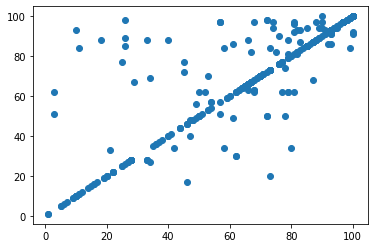

In [ ]:
plt.scatter(true, predictions)

In [ ]:
r2_score(true, predictions)

0.6838949660776262

### can this be data leakage?

First, check if there are duplicated reaction SMILES.

In [ ]:
len(data) - len(data['reaction_smiles'].unique())

846

ok, there are several duplicates

now, let's try to be more careful here and just split the reaction SMILES into train and test sets.

In [ ]:
train_reaction_smiles, test_reaction_smiles = train_test_split(data['reaction_smiles'].unique(), train_size=0.8)

In [ ]:
train_data = data[data['reaction_smiles'].isin(train_reaction_smiles)]
test_data = data[data['reaction_smiles'].isin(test_reaction_smiles)]

In [ ]:
train_prompts = create_reaction_yield_prompts(train_data) 
test_prompts = create_reaction_yield_prompts(test_data)

In [ ]:
train_size  = len(train_prompts)
test_size = len(test_prompts)

filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename = f"run_files/{filename_base}_train_prompts_uspto_yield_regression_{train_size}.jsonl"
valid_filename = f"run_files/{filename_base}_valid_prompts_uspto_yield_regression_{test_size}.jsonl"

train_prompts.to_json(train_filename, orient="records", lines=True)
test_prompts.to_json(valid_filename, orient="records", lines=True)


In [ ]:
fine_tune(train_filename, valid_filename)

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

'ada:ft-lsmoepfl-2022-10-13-13-19-56'

In [ ]:
completions = query_gpt3('ada:ft-lsmoepfl-2022-10-13-13-19-56', test_prompts)

In [ ]:
predictions = np.array([extract_regression_prediction(completions, i) for i, completion in enumerate(completions["choices"])])
true = test_prompts['completion'].apply(lambda x: int(x.split('@@@')[0])).values

<matplotlib.collections.PathCollection>

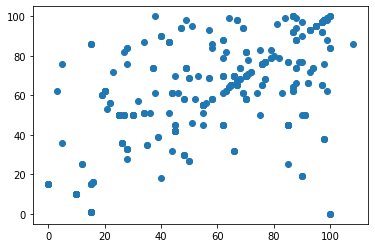

In [ ]:
plt.scatter(true, predictions)

In [ ]:
not_nan = ~pd.isna(predictions)

In [ ]:
r2_score(true[not_nan], predictions[not_nan])

0.19808815914679423

In [ ]:
len(train_data)

1218

### Now, add reaction SMILES

In [ ]:
train_prompts = create_reaction_yield_prompts(train_data, include_reaction_smiles=True) 
test_prompts = create_reaction_yield_prompts(test_data, include_reaction_smiles=True)

In [ ]:
train_size  = len(train_prompts)
test_size = len(test_prompts)

filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename = f"run_files/{filename_base}_train_prompts_uspto_yield_regression_{train_size}.jsonl"
valid_filename = f"run_files/{filename_base}_valid_prompts_uspto_yield_regression_{test_size}.jsonl"

train_prompts.to_json(train_filename, orient="records", lines=True)
test_prompts.to_json(valid_filename, orient="records", lines=True)


In [ ]:
fine_tune(train_filename, valid_filename)

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

'ada:ft-lsmoepfl-2022-10-13-13-43-43'

In [ ]:
completions = query_gpt3('ada:ft-lsmoepfl-2022-10-13-13-43-43', test_prompts)

In [ ]:
predictions = np.array([extract_regression_prediction(completions, i) for i, completion in enumerate(completions["choices"])])
true = test_prompts['completion'].apply(lambda x: int(x.split('@@@')[0])).values

<matplotlib.collections.PathCollection>

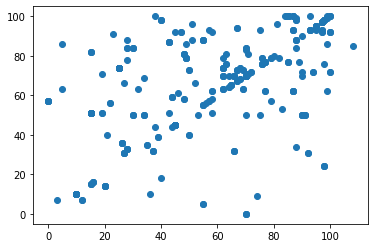

In [ ]:
plt.scatter(true, predictions)

In [ ]:
not_nan = ~pd.isna(predictions)

In [ ]:
r2_score(true[not_nan], predictions[not_nan])

0.10309063282769448

In [ ]:
len(train_data)

1218

## Now only reaction SMILES

In [ ]:
train_prompts = create_reaction_yield_prompts(train_data, only_reaction_smiles=True) 
test_prompts = create_reaction_yield_prompts(test_data, only_reaction_smiles=True)

In [ ]:
train_size  = len(train_prompts)
test_size = len(test_prompts)

filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename = f"run_files/{filename_base}_train_prompts_uspto_yield_regression_{train_size}.jsonl"
valid_filename = f"run_files/{filename_base}_valid_prompts_uspto_yield_regression_{test_size}.jsonl"

train_prompts.to_json(train_filename, orient="records", lines=True)
test_prompts.to_json(valid_filename, orient="records", lines=True)


In [ ]:
fine_tune(train_filename, valid_filename)

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

'ada:ft-lsmoepfl-2022-10-13-14-29-08'

In [ ]:
completions = query_gpt3('ada:ft-lsmoepfl-2022-10-13-14-29-08', test_prompts)

In [ ]:
predictions = np.array([extract_regression_prediction(completions, i) for i, completion in enumerate(completions["choices"])])
true = test_prompts['completion'].apply(lambda x: int(x.split('@@@')[0])).values

<matplotlib.collections.PathCollection>

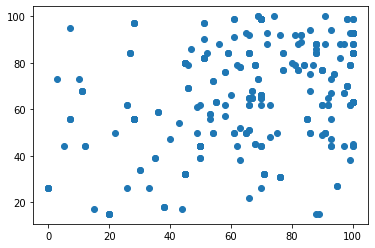

In [ ]:
plt.scatter(true, predictions)

In [ ]:
not_nan = ~pd.isna(predictions)

In [ ]:
r2_score(true[not_nan], predictions[not_nan])

-0.06202642117909174

### Do one last experiment where we look at the scale of the reaction 

(array([  5.,  57., 305., 378., 353., 257., 137.,  56.,   5.,   2.]),
 array([-7.18219212, -5.51914748, -3.85610284, -2.1930582 , -0.53001355,
         1.13303109,  2.79607573,  4.45912037,  6.12216502,  7.78520966,
         9.4482543 ]),
 <BarContainer object of 10 artists>)

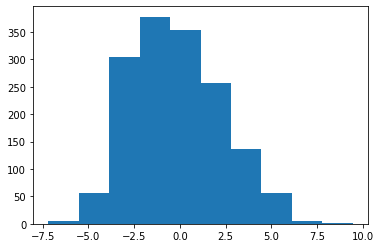

In [ ]:
plt.hist(np.log(data['mass']))

In [ ]:
small_scale_reactions = data[data['mass'] <1]

In [ ]:
train_reaction_smiles_small_scale_reactions, test_reaction_smiles_small_scale_reactions = train_test_split(small_scale_reactions['reaction_smiles'].unique(), train_size=0.8)

In [ ]:
train_data_small_scale_reactions = small_scale_reactions[small_scale_reactions['reaction_smiles'].isin(train_reaction_smiles_small_scale_reactions)]
test_data_small_scale_reactions = small_scale_reactions[small_scale_reactions['reaction_smiles'].isin(test_reaction_smiles_small_scale_reactions)]

In [ ]:
train_prompts_small_scale_reactions = create_reaction_yield_prompts(train_data_small_scale_reactions, include_reaction_smiles=False) 
test_prompts_small_scale_reactions = create_reaction_yield_prompts(test_data_small_scale_reactions, include_reaction_smiles=False)

In [ ]:
train_size  = len(train_prompts)
test_size = len(test_prompts)

filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename_small_scale_reactions = f"run_files/{filename_base}_train_prompts_uspto_yield_small_scale_regression_{train_size}.jsonl"
valid_filename_small_scale_reactions = f"run_files/{filename_base}_valid_prompts_uspto_yield_small_scale_regression_{test_size}.jsonl"

train_prompts_small_scale_reactions.to_json(train_filename_small_scale_reactions, orient="records", lines=True)
test_prompts_small_scale_reactions.to_json(valid_filename_small_scale_reactions, orient="records", lines=True)


In [ ]:
fine_tune(train_filename_small_scale_reactions, valid_filename_small_scale_reactions)

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

'ada:ft-lsmoepfl-2022-10-13-14-54-19'

In [ ]:
completions = query_gpt3('ada:ft-lsmoepfl-2022-10-13-14-54-19', test_prompts_small_scale_reactions)

In [ ]:
predictions = np.array([extract_regression_prediction(completions, i) for i, completion in enumerate(completions["choices"])])
true = test_prompts_small_scale_reactions['completion'].apply(lambda x: int(x.split('@@@')[0])).values

<matplotlib.collections.PathCollection>

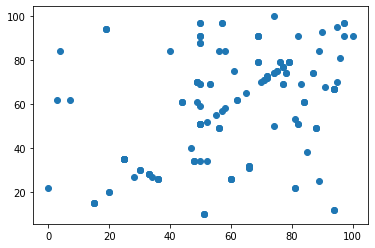

In [ ]:
plt.scatter(true, predictions)

In [ ]:
not_nan = ~pd.isna(predictions)

In [ ]:
r2_score(true[not_nan], predictions[not_nan])

-0.3055075575835864